### Imports

In [223]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

#!pip install imblearn
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.2.2
#from imblearn.over_sampling import SMOTENC
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

import category_encoders as ce
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

random_state = 42
np.random.seed(42)

## Additional Preprocessing for Multiclass

In [224]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')

In [225]:
#encoding for multiclass variable
mapping = {'No': 0, '<30 days': 1, '>30 days': 2}
df_train['readmitted_multiclass'] = df_train['readmitted_multiclass'].map(mapping)

#### Admission_Source

In [226]:
#Fill NA's with Unknown
df_train['admission_source'] = df_train['admission_source'].fillna("Unknown")

In [227]:
#Calculate the overall proportion for each class in 'readmitted_multiclass'
overall_proportion = df_train['readmitted_multiclass'].value_counts(normalize=True)
overall_proportion

0    0.539123
2    0.349276
1    0.111601
Name: readmitted_multiclass, dtype: float64

In [228]:
#Calculate the proportion of each class within each 'admission_source' and create columns
counts_per_admission_source = df_train.groupby(['admission_source', 'readmitted_multiclass']).size()
total_counts_per_admission_source = df_train['admission_source'].value_counts()
admission_source_proportion = counts_per_admission_source.div(total_counts_per_admission_source, level='admission_source').unstack(fill_value=0)
admission_source_proportion

readmitted_multiclass,0,1,2
admission_source,,,
Court/Law Enforcement,0.636364,0.181818,0.181818
Emergency Room,0.506982,0.116620,0.376398
Extramural Birth,1.000000,0.000000,0.000000
Not Available,0.772727,0.079545,0.147727
Physician Referral,0.569881,0.105184,0.324935
Sick Baby,1.000000,0.000000,0.000000
Transfer from Ambulatory Surgery Center,1.000000,0.000000,0.000000
Transfer from a Skilled Nursing Facility (SNF),0.589916,0.127731,0.282353
Transfer from another health care facility,0.727273,0.097311,0.175416


In [229]:
#Aggregate less common Admission Sources in one category
df_train['admission_source'] = df_train['admission_source'].apply(
    lambda x: 'Other Admission Source' 
    if x in ['HMO Referral', ' Court/Law Enforcement', 
             ' Transfer from hospital inpt/same fac reslt in a sep claim', 
             ' Transfer from critial access hospital', 
             ' Transfer from Ambulatory Surgery Center', 
             ' Extramural Birth', 'Normal Delivery', ' Sick Baby'] 
    else x
)

In [230]:
admission_source_proportion_reset = admission_source_proportion.reset_index()
df_train = df_train.merge(admission_source_proportion_reset, on='admission_source', how='left')

df_train.rename(columns={0: 'admission_source_0', 1:'admission_source_1', 2:'admission_source_2'}, inplace=True)

In [231]:
#create bins comparing the average of readmitted multiclass and the average of each class in admission source
df_train['admission_source_0_high'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['admission_source_0_low'] = df_train['admission_source_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['admission_source_1_high'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['admission_source_1_low'] = df_train['admission_source_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['admission_source_2_high'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['admission_source_2_low'] = df_train['admission_source_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Medical_specialty

In [232]:
# Replacing missing values in 'medical_specialty' with a placeholder 'Unknown'
df_train['medical_specialty'].fillna('Unknown', inplace=True)

In [233]:
#calculate the proportion of each class within each 'medical_specialty' and create columns
counts_per_medical_specialty = df_train.groupby(['medical_specialty', 'readmitted_multiclass']).size()
total_counts_per_medical_specialty = df_train['medical_specialty'].value_counts()
medical_specialty_proportion = counts_per_medical_specialty.div(total_counts_per_medical_specialty, level='medical_specialty').unstack(fill_value=0)
medical_specialty_proportion

readmitted_multiclass,0,1,2
medical_specialty,,,
AllergyandImmunology,0.166667,0.500000,0.333333
Anesthesiology,0.800000,0.000000,0.200000
Anesthesiology-Pediatric,0.666667,0.000000,0.333333
Cardiology,0.572659,0.079386,0.347955
Cardiology-Pediatric,0.200000,0.200000,0.600000
...,...,...,...
Surgery-Thoracic,0.614458,0.096386,0.289157
Surgery-Vascular,0.498630,0.147945,0.353425
SurgicalSpecialty,0.640000,0.080000,0.280000


In [234]:
#reset the index
medical_specialty_proportion_reset = medical_specialty_proportion.reset_index()
df_train = df_train.merge(medical_specialty_proportion_reset, on='medical_specialty', how='left')

#rename the columns
df_train.rename(columns={0: 'medical_specialty_0', 1: 'medical_specialty_1', 2: 'medical_specialty_2'}, inplace=True)

In [235]:
#create bins comparing the proportion of each readmitted multiclass and the proportion of each class in medical specialty
df_train['medical_specialty_0_high'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['medical_specialty_0_low'] = df_train['medical_specialty_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['medical_specialty_1_high'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['medical_specialty_1_low'] = df_train['medical_specialty_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['medical_specialty_2_high'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['medical_specialty_2_low'] = df_train['medical_specialty_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Discharge_disposition

In [236]:
df_train['discharge_disposition'] = df_train['discharge_disposition'].fillna("Unknown")

In [237]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_discharge_disposition = df_train.groupby(['discharge_disposition', 'readmitted_multiclass']).size()
total_counts_per_discharge_disposition = df_train['discharge_disposition'].value_counts()

discharge_disposition_proportion = counts_per_discharge_disposition.div(total_counts_per_discharge_disposition, level='discharge_disposition').unstack(fill_value=0)

In [238]:
discharge_disposition_proportion_reset = discharge_disposition_proportion.reset_index()

df_train = df_train.merge(discharge_disposition_proportion_reset, on='discharge_disposition', how='left')

df_train.rename(columns={0: 'discharge_disposition_0', 1: 'discharge_disposition_1', 2: 'discharge_disposition_2'}, inplace=True)

In [239]:
#create bins comparing the proportion of each readmitted multiclass and the proportion of each class in discharge disposition
df_train['discharge_disposition_0_high'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['discharge_disposition_0_low'] = df_train['discharge_disposition_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['discharge_disposition_1_high'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['discharge_disposition_1_low'] = df_train['discharge_disposition_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['discharge_disposition_2_high'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['discharge_disposition_2_low'] = df_train['discharge_disposition_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)

#### Diagnosis variables 

Primary Diagnosis

In [240]:
#same logic as before, calculate the proportion of each class within each 'primary diagnosis' and create columns accordingly
counts_per_primary_diagnosis = df_train.groupby(['primary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_primary_diagnosis = df_train['primary_diagnosis'].value_counts()

primary_diagnosis_proportion = counts_per_primary_diagnosis.div(total_counts_per_primary_diagnosis, level='primary_diagnosis').unstack(fill_value=0)

In [241]:
primary_diagnosis_proportion_reset = primary_diagnosis_proportion.reset_index()

df_train = df_train.merge(primary_diagnosis_proportion_reset, on='primary_diagnosis', how='left')

df_train.rename(columns={0: 'primary_diagnosis_0', 1: 'primary_diagnosis_1', 2: 'primary_diagnosis_2'}, inplace=True)

In [242]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['primary_diagnosis_0_high'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['primary_diagnosis_0_low'] = df_train['primary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['primary_diagnosis_1_high'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['primary_diagnosis_1_low'] = df_train['primary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['primary_diagnosis_2_high'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['primary_diagnosis_2_low'] = df_train['primary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)



Secondary Diagnosis

In [243]:
# Same logic as before, calculate the proportion of each class within each 'discharge_disposition' and create columns accordingly
counts_per_secondary_diagnosis = df_train.groupby(['secondary_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_secondary_diagnosis = df_train['secondary_diagnosis'].value_counts()

secondary_diagnosis_proportion = counts_per_secondary_diagnosis.div(total_counts_per_secondary_diagnosis, level='secondary_diagnosis').unstack(fill_value=0)
secondary_diagnosis_proportion_reset = secondary_diagnosis_proportion.reset_index()

In [244]:
df_train = df_train.merge(secondary_diagnosis_proportion_reset, on='secondary_diagnosis', how='left')

df_train.rename(columns={0: 'secondary_diagnosis_0', 1: 'secondary_diagnosis_1', 2: 'secondary_diagnosis_2'}, inplace=True)

In [245]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['secondary_diagnosis_0_high'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['secondary_diagnosis_0_low'] = df_train['secondary_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['secondary_diagnosis_1_high'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['secondary_diagnosis_1_low'] = df_train['secondary_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['secondary_diagnosis_2_high'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['secondary_diagnosis_2_low'] = df_train['secondary_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)




Additional Diagnosis

In [246]:
# Same logic as before, calculate the proportion of each class within each 'additional_diagnosis' and create columns accordingly
counts_per_additional_diagnosis = df_train.groupby(['additional_diagnosis', 'readmitted_multiclass']).size()
total_counts_per_additional_diagnosis = df_train['additional_diagnosis'].value_counts()

additional_diagnosis_proportion = counts_per_additional_diagnosis.div(total_counts_per_additional_diagnosis, level='additional_diagnosis').unstack(fill_value=0)

In [247]:
additional_diagnosis_proportion_reset = additional_diagnosis_proportion.reset_index()

df_train = df_train.merge(additional_diagnosis_proportion_reset, on='additional_diagnosis', how='left')

df_train.rename(columns={0: 'additional_diagnosis_0', 1: 'additional_diagnosis_1', 2: 'additional_diagnosis_2'}, inplace=True)

In [248]:
#Create bins comparing the proportion of each readmitted multiclass and the proportion of each class in primary diagnosis
df_train['additional_diagnosis_0_high'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x >= 0.6
                                                                            else 0)

df_train['additional_diagnosis_0_low'] = df_train['additional_diagnosis_0'].apply(lambda x: 1 
                                                                           if x < 0.5
                                                                            else 0)

df_train['additional_diagnosis_1_high'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x >= 0.12
                                                                            else 0)

df_train['additional_diagnosis_1_low'] = df_train['additional_diagnosis_1'].apply(lambda x: 1 
                                                                           if x < 0.1
                                                                            else 0)

df_train['additional_diagnosis_2_high'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x >= 0.4
                                                                            else 0)

df_train['additional_diagnosis_2_low'] = df_train['additional_diagnosis_2'].apply(lambda x: 1 
                                                                           if x < 0.3
                                                                            else 0)


## Model and feature selection

### Set train and test data

In [249]:
categorical_columns = ['race',
       'payer_code',  'admission_type',
       'medical_specialty',  'discharge_disposition',
       'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'has_weight', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'race_nan', 'payer_code_HM', 'payer_code_MC',
       'payer_code_MD', 'payer_code_No provider', 'payer_code_Other provider',
       'payer_code_SP', 
       'more_than_one_lab_test', 

       'admission_type_big_share', 'admission_type_big_share_Elective',
       'admission_type_big_share_Emergency', 'admission_type_big_share_Urgent',

       'medical_specialty_0_high', 'medical_specialty_0_low', 'medical_specialty_1_high', 
       'medical_specialty_1_low', 'medical_specialty_2_high', 'medical_specialty_2_low',

       'admission_source_0_high',	'admission_source_0_low',	'admission_source_1_high',	'admission_source_1_low',
       'admission_source_2_high',	'admission_source_2_low',

       'discharge_disposition_0_high', 'discharge_disposition_0_low',
       'discharge_disposition_1_high', 'discharge_disposition_1_low',
       'discharge_disposition_2_high', 'discharge_disposition_2_low',
                  
       'primary_diagnosis_2_low', 'primary_diagnosis_2_high','primary_diagnosis_1_low',
       'primary_diagnosis_1_high','primary_diagnosis_0_low','primary_diagnosis_0_high',

       'secondary_diagnosis_2_low', 'secondary_diagnosis_2_high','secondary_diagnosis_1_low',
       'secondary_diagnosis_1_high','secondary_diagnosis_0_low','secondary_diagnosis_0_high',                   
                   
       'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
       'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
       'additional_diagnosis_2_high', 'additional_diagnosis_2_low',
       
       'primary_diagnosis_category',
       'secondary_diagnosis_category', 'additional_diagnosis_category',
       'high_primary_diagnosis_category', 'medium_primary_diagnosis_category',
       'low_primary_diagnosis_category', 'high_secondary_diagnosis_category',
       'medium_secondary_diagnosis_category',
       'low_secondary_diagnosis_category',
       'high_additional_diagnosis_category',
       'medium_additional_diagnosis_category',
       'low_additional_diagnosis_category', 'diabetes_diagnosis',
       'diabetes_diagnosis_4_digits', 'diabetes_type',
       'diabetes_severity_group', 'diabetes_severity_group_Mild',
       'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
       'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
       'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
       'glucose_test_performed', 'a1c_test_performed', 
       'metformin', 'rosiglitazone', 'glyburide', 'insulin', 'glipizide',
       'repaglinide', 'glimepiride', 'pioglitazone']

df_train[categorical_columns] = df_train[categorical_columns].astype('category')

In [250]:
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 

                  'medical_specialty_0_high', 'medical_specialty_0_low', 'medical_specialty_1_high', 
                  'medical_specialty_1_low', 'medical_specialty_2_high', 'medical_specialty_2_low',

                  'admission_source_0_high',	'admission_source_0_low',	'admission_source_1_high',	'admission_source_1_low',
                  'admission_source_2_high',	'admission_source_2_low',

                  'discharge_disposition_0_high', 'discharge_disposition_0_low',
                  'discharge_disposition_1_high', 'discharge_disposition_1_low',
                  'discharge_disposition_2_high', 'discharge_disposition_2_low',
                  
                  'primary_diagnosis_2_low', 'primary_diagnosis_2_high','primary_diagnosis_1_low',
                  'primary_diagnosis_1_high','primary_diagnosis_0_low','primary_diagnosis_0_high',

                  'secondary_diagnosis_2_low', 'secondary_diagnosis_2_high','secondary_diagnosis_1_low',
                  'secondary_diagnosis_1_high','secondary_diagnosis_0_low','secondary_diagnosis_0_high',                   
                   
                  'additional_diagnosis_0_high', 'additional_diagnosis_0_low',
                  'additional_diagnosis_1_high', 'additional_diagnosis_1_low',
                  'additional_diagnosis_2_high', 'additional_diagnosis_2_low',
                                
                  'number_lab_tests',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_performed', 'glucose_test_result',
                   'a1c_test_result',
        
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_No provider',
                  'payer_code_Other provider',        
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 

In [251]:
data = df_train[columns_to_use]
target = df_train['readmitted_multiclass']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### Functions for Modeling

In [252]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    transform_data[features_for_encoding_pass] = np.array(encoded_df)
    encoded_df = transform_data.drop(columns = features_for_encoding)
    # encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
    #                     pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [253]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [254]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id')
    df_train['patient_total_visits'].fillna(0, inplace = True)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id')
    df_test['patient_total_visits'].fillna(0, inplace = True)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_train[['patient_num_readmitted', 'patient_was_readmitted']] = df_train[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id')
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].fillna(0).astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [255]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [256]:
def plot_metrics(result, params, best_models, figsize_param = (30,40)):

    fig,ax = plt.subplots(ncols = len(result[0][1]), nrows = len(params), figsize = figsize_param)
    
    for m in range(len(result[0][1])):
        for key in range(len(list(params.keys()))):
            hyperparam = list(params.keys())[key]
            metric = list(result[0][1].keys())[m]
            hyperparam_df = pd.DataFrame([(best_models[i][0][hyperparam], best_models[i][1][metric][1]) for i in range(len(best_models))], 
                                         columns = ['hyperparameter', metric]).fillna('None')
            if hyperparam_df['hyperparameter'].dtype == 'O':
                hyperparam_df['hyperparameter'] = hyperparam_df['hyperparameter'].astype(str)
            hyperparam_df = hyperparam_df.sort_values(by='hyperparameter')
            
            ax[key, m].boxplot([group[1][metric].values for group in hyperparam_df.groupby('hyperparameter')],
            labels = [np.round(i, 4) if isinstance(i, float) else i for i in hyperparam_df['hyperparameter'].unique()],
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4)
                              ) 
            ax[key, m].tick_params(axis='x', labelsize=10)
            ax[key, m].set_title(hyperparam + ' - ' + metric)
    
            ax[key, m].xaxis.grid(False)
            ax[key, m].yaxis.grid(False)
    plt.tight_layout()
    
    # plt.savefig('rf_feature_selection_hyperparams.png')
    plt.show()

In [269]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)
    

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in tqdm(range(cv)):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]

        #Target encoding
        if target_encoding == True:
                val_data = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)[0]
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale
 
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]


        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        # Get probability predictions
        y_pred_train_proba = model.predict_proba(X_train)
        y_pred_val_proba = model.predict_proba(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'weighted'), f1_score(y_val, y_pred_val, average = 'weighted')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'weighted'), recall_score(y_val, y_pred_val, average = 'weighted')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'weighted'), precision_score(y_val, y_pred_val, average = 'weighted')])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train_proba, multi_class='ovr', average = 'weighted'), roc_auc_score(y_val, y_pred_val_proba, multi_class='ovr', average = 'weighted')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.median(np.array(feature_imp), axis = 0),
            ]

In [264]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

data = pd.concat([X_train, y_train], axis = 1)
data.reset_index(inplace = True)

target = 'readmitted_multiclass'

### Feature selection

#### Random Forest MDI

In [270]:
model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(6, 30, 2),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.1,0.7,0.1)
}

result = []
for i in tqdm(range(50)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     multiclass = True,      
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))

  2%|▏         | 1/50 [01:59<1:37:13, 119.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=18, max_features=0.5,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.627, F1_val: 0.601


  4%|▍         | 2/50 [03:07<1:11:31, 89.40s/it] 

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000201, n_estimators=190,
                       random_state=42)
F1 train: 0.665, F1_val: 0.615


  6%|▌         | 3/50 [04:29<1:07:10, 85.76s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.6,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.615, F1_val: 0.597


  8%|▊         | 4/50 [05:25<56:43, 73.99s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.5,
                       min_samples_leaf=0.001801, min_samples_split=0.000101,
                       n_estimators=150, random_state=42)
F1 train: 0.606, F1_val: 0.596


 10%|█         | 5/50 [05:59<44:48, 59.75s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.4,
                       min_samples_leaf=0.001001, min_samples_split=0.000201,
                       n_estimators=70, random_state=42)
F1 train: 0.648, F1_val: 0.609


 12%|█▏        | 6/50 [06:20<34:04, 46.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0008010000000000001, n_estimators=70,
                       random_state=42)
F1 train: 0.700, F1_val: 0.625


 14%|█▍        | 7/50 [07:15<35:20, 49.30s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000101, n_estimators=250,
                       random_state=42)
F1 train: 0.632, F1_val: 0.606


 16%|█▌        | 8/50 [08:11<36:05, 51.55s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, max_features=0.2,
                       min_samples_leaf=0.001201, min_samples_split=0.000501,
                       n_estimators=250, random_state=42)
F1 train: 0.619, F1_val: 0.600


 18%|█▊        | 9/50 [08:31<28:24, 41.57s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.1,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=110,
                       random_state=42)
F1 train: 0.656, F1_val: 0.610


 20%|██        | 10/50 [10:51<48:03, 72.09s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.4,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.725, F1_val: 0.627


 22%|██▏       | 11/50 [11:52<44:40, 68.73s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.6, min_samples_leaf=1e-06,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=90, random_state=42)
F1 train: 0.732, F1_val: 0.631


 24%|██▍       | 12/50 [12:33<38:11, 60.29s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12, max_features=0.6,
                       min_samples_leaf=0.001201,
                       min_samples_split=0.0008010000000000001, n_estimators=70,
                       random_state=42)
F1 train: 0.636, F1_val: 0.604


 26%|██▌       | 13/50 [14:08<43:40, 70.83s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=16, max_features=0.2,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=270, random_state=42)
F1 train: 0.753, F1_val: 0.636


 28%|██▊       | 14/50 [14:36<34:43, 57.87s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=18, max_features=0.30000000000000004,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000501, n_estimators=70,
                       random_state=42)
F1 train: 0.657, F1_val: 0.613


 30%|███       | 15/50 [15:56<37:36, 64.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4, min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=150, random_state=42)
F1 train: 0.753, F1_val: 0.637


 32%|███▏      | 16/50 [17:44<43:57, 77.58s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.6,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=150, random_state=42)
F1 train: 0.740, F1_val: 0.630


 34%|███▍      | 17/50 [18:22<36:03, 65.56s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.6,
                       min_samples_leaf=0.001601, min_samples_split=0.000501,
                       n_estimators=70, random_state=42)
F1 train: 0.619, F1_val: 0.597


 36%|███▌      | 18/50 [19:55<39:21, 73.79s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=18, max_features=0.5,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.652, F1_val: 0.610


 38%|███▊      | 19/50 [20:29<31:55, 61.78s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=110, random_state=42)
F1 train: 0.671, F1_val: 0.616


 40%|████      | 20/50 [21:02<26:35, 53.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.6,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000201, n_estimators=50,
                       random_state=42)
F1 train: 0.667, F1_val: 0.615


 42%|████▏     | 21/50 [21:51<25:06, 51.94s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=18, max_features=0.1,
                       min_samples_leaf=0.001201, min_samples_split=0.000701,
                       n_estimators=270, random_state=42)
F1 train: 0.619, F1_val: 0.598


 44%|████▍     | 22/50 [23:37<31:51, 68.26s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000501, n_estimators=230,
                       random_state=42)
F1 train: 0.665, F1_val: 0.614


 46%|████▌     | 23/50 [24:28<28:18, 62.91s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.1, min_samples_leaf=1e-06,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=270, random_state=42)
F1 train: 0.717, F1_val: 0.629


 48%|████▊     | 24/50 [24:54<22:31, 51.99s/it]

RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=0.1,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=230, random_state=42)
F1 train: 0.600, F1_val: 0.592


 50%|█████     | 25/50 [25:43<21:18, 51.13s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=14, max_features=0.2,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=210, random_state=42)
F1 train: 0.618, F1_val: 0.598


 52%|█████▏    | 26/50 [26:48<22:04, 55.19s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=0.2, min_samples_leaf=1e-06,
                       min_samples_split=0.000701, n_estimators=210,
                       random_state=42)
F1 train: 0.729, F1_val: 0.633


 54%|█████▍    | 27/50 [27:13<17:39, 46.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=24, max_features=0.2,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=70,
                       random_state=42)
F1 train: 0.703, F1_val: 0.624


 56%|█████▌    | 28/50 [28:57<23:16, 63.48s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=10, max_features=0.6,
                       min_samples_leaf=0.000201, min_samples_split=0.000501,
                       n_estimators=170, random_state=42)
F1 train: 0.667, F1_val: 0.617


 58%|█████▊    | 29/50 [29:44<20:28, 58.50s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=22, max_features=0.4,
                       min_samples_leaf=0.001801, min_samples_split=1e-06,
                       n_estimators=110, random_state=42)
F1 train: 0.618, F1_val: 0.596


 60%|██████    | 30/50 [30:31<18:24, 55.23s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=16, max_features=0.5,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=70, random_state=42)
F1 train: 0.778, F1_val: 0.636


 62%|██████▏   | 31/50 [31:17<16:34, 52.35s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=26, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=70,
                       random_state=42)
F1 train: 0.727, F1_val: 0.627


 64%|██████▍   | 32/50 [32:35<18:03, 60.21s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=8, max_features=0.4, min_samples_leaf=0.001201,
                       min_samples_split=0.0006010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.606, F1_val: 0.594


 66%|██████▌   | 33/50 [33:35<16:59, 59.96s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=24, max_features=0.2,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=250, random_state=42)
F1 train: 0.619, F1_val: 0.599


 68%|██████▊   | 34/50 [34:42<16:34, 62.14s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=20, max_features=0.30000000000000004,
                       min_samples_leaf=0.001801,
                       min_samples_split=0.00040100000000000004,
                       n_estimators=210, random_state=42)
F1 train: 0.617, F1_val: 0.597


 70%|███████   | 35/50 [35:11<13:04, 52.33s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.4,
                       min_samples_leaf=0.001601, min_samples_split=0.000201,
                       n_estimators=70, random_state=42)
F1 train: 0.624, F1_val: 0.601


 72%|███████▏  | 36/50 [35:40<10:30, 45.06s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.5, min_samples_leaf=0.001401,
                       min_samples_split=1e-06, n_estimators=90,
                       random_state=42)
F1 train: 0.584, F1_val: 0.584


 74%|███████▍  | 37/50 [37:14<13:00, 60.03s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.6,
                       min_samples_leaf=1e-06,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.774, F1_val: 0.637


 76%|███████▌  | 38/50 [37:41<10:00, 50.08s/it]

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=22, max_features=0.2, min_samples_leaf=1e-06,
                       min_samples_split=0.000501, n_estimators=70,
                       random_state=42)
F1 train: 0.832, F1_val: 0.639


 78%|███████▊  | 39/50 [39:34<12:38, 68.96s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features=0.5,
                       min_samples_leaf=0.001601,
                       min_samples_split=0.0009010000000000001,
                       n_estimators=250, random_state=42)
F1 train: 0.618, F1_val: 0.598


 80%|████████  | 40/50 [40:14<10:01, 60.12s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.1,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=290, random_state=42)
F1 train: 0.643, F1_val: 0.610


 82%|████████▏ | 41/50 [41:47<10:29, 69.95s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=24, max_features=0.5,
                       min_samples_leaf=0.001401,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=190, random_state=42)
F1 train: 0.633, F1_val: 0.603


 84%|████████▍ | 42/50 [43:38<10:59, 82.38s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.735, F1_val: 0.630


 86%|████████▌ | 43/50 [44:47<09:08, 78.32s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.001201, min_samples_split=0.000101,
                       n_estimators=210, random_state=42)
F1 train: 0.641, F1_val: 0.608


 88%|████████▊ | 44/50 [45:06<06:03, 60.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=24, max_features=0.2,
                       min_samples_leaf=0.001401, min_samples_split=0.000201,
                       n_estimators=70, random_state=42)
F1 train: 0.622, F1_val: 0.601


 90%|█████████ | 45/50 [46:24<05:29, 65.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=170, random_state=42)
F1 train: 0.672, F1_val: 0.620


 92%|█████████▏| 46/50 [48:31<05:36, 84.07s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.5,
                       min_samples_leaf=0.001601, min_samples_split=0.000701,
                       n_estimators=270, random_state=42)
F1 train: 0.632, F1_val: 0.604


 94%|█████████▍| 47/50 [49:23<03:43, 74.56s/it]

RandomForestClassifier(class_weight='balanced_subsample', criterion='log_loss',
                       max_depth=12, max_features=0.6,
                       min_samples_leaf=0.001601, min_samples_split=1e-06,
                       n_estimators=90, random_state=42)
F1 train: 0.624, F1_val: 0.600


 96%|█████████▌| 48/50 [50:56<02:39, 79.86s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=8,
                       max_features=0.5,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000201, n_estimators=230,
                       random_state=42)
F1 train: 0.621, F1_val: 0.604


 98%|█████████▊| 49/50 [52:28<01:23, 83.60s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.4,
                       min_samples_leaf=0.0008010000000000001,
                       min_samples_split=0.000701, n_estimators=210,
                       random_state=42)
F1 train: 0.669, F1_val: 0.617


100%|██████████| 50/50 [53:50<00:00, 64.62s/it]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=28, max_features=0.30000000000000004,
                       min_samples_leaf=0.001001,
                       min_samples_split=0.0008010000000000001,
                       n_estimators=230, random_state=42)
F1 train: 0.647, F1_val: 0.609


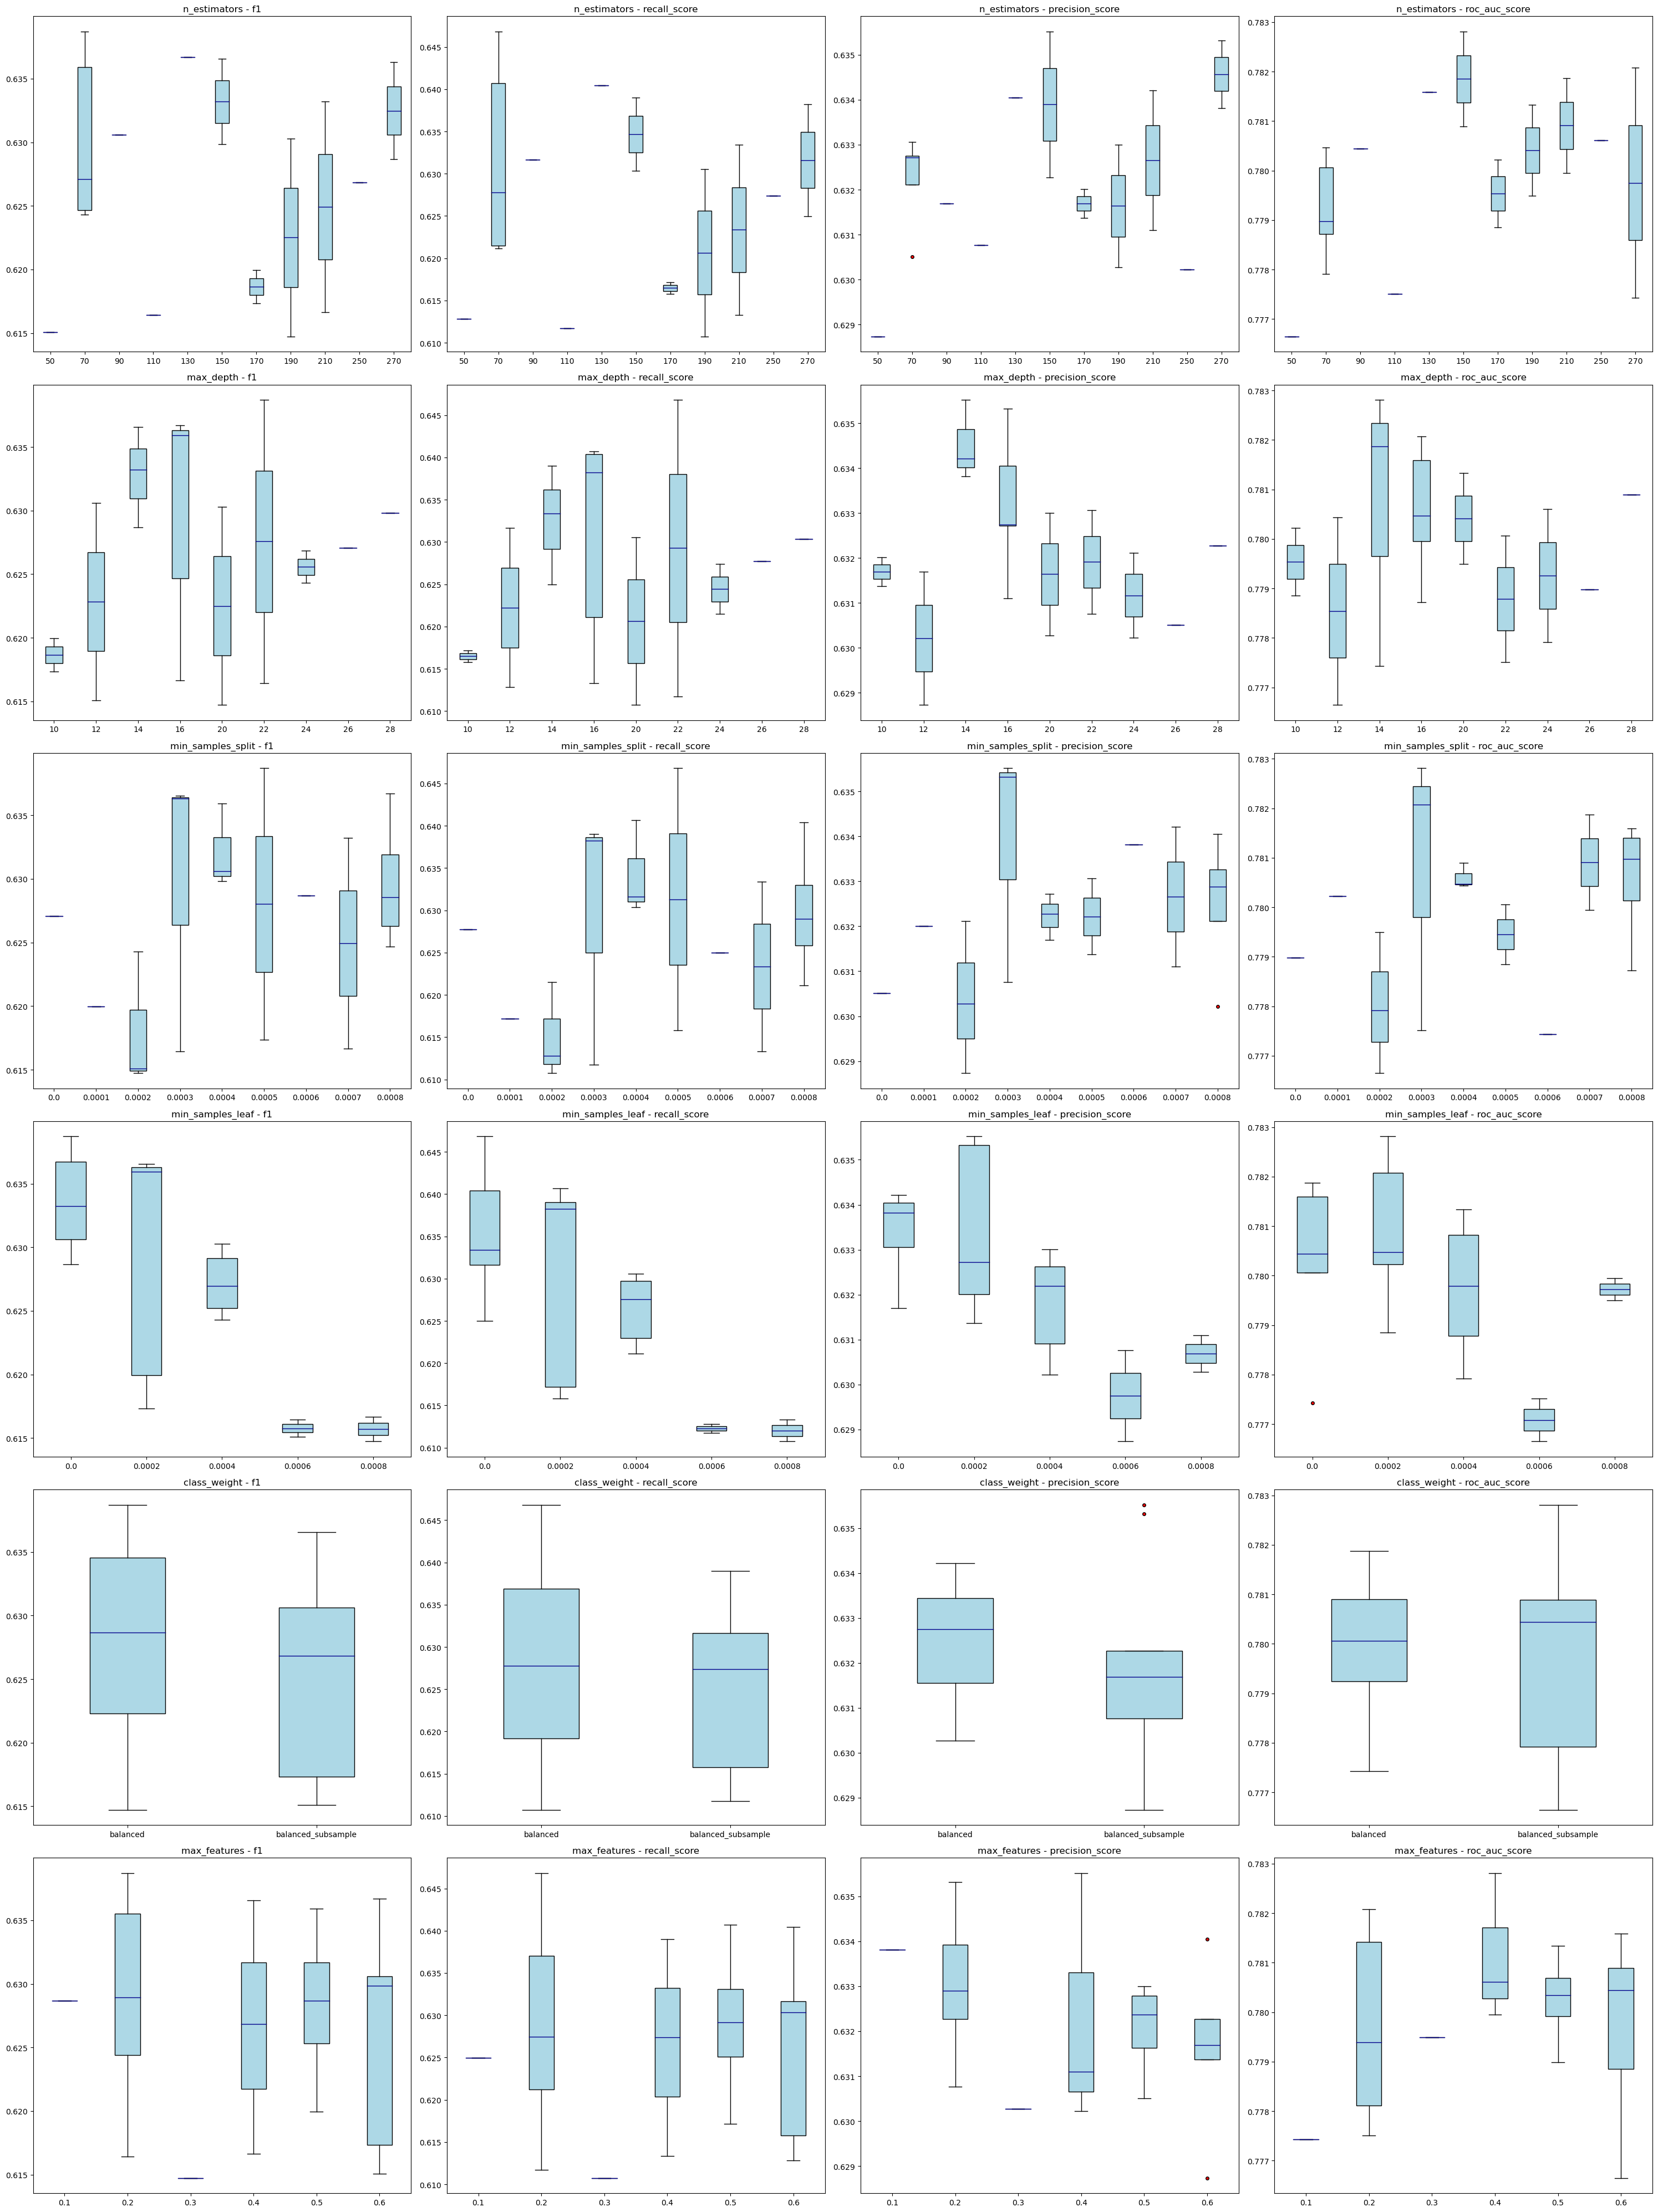

In [281]:
num_best_models = 20

best_models = sorted(result, key=lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(result, params, best_models, figsize_param=(30, 40))

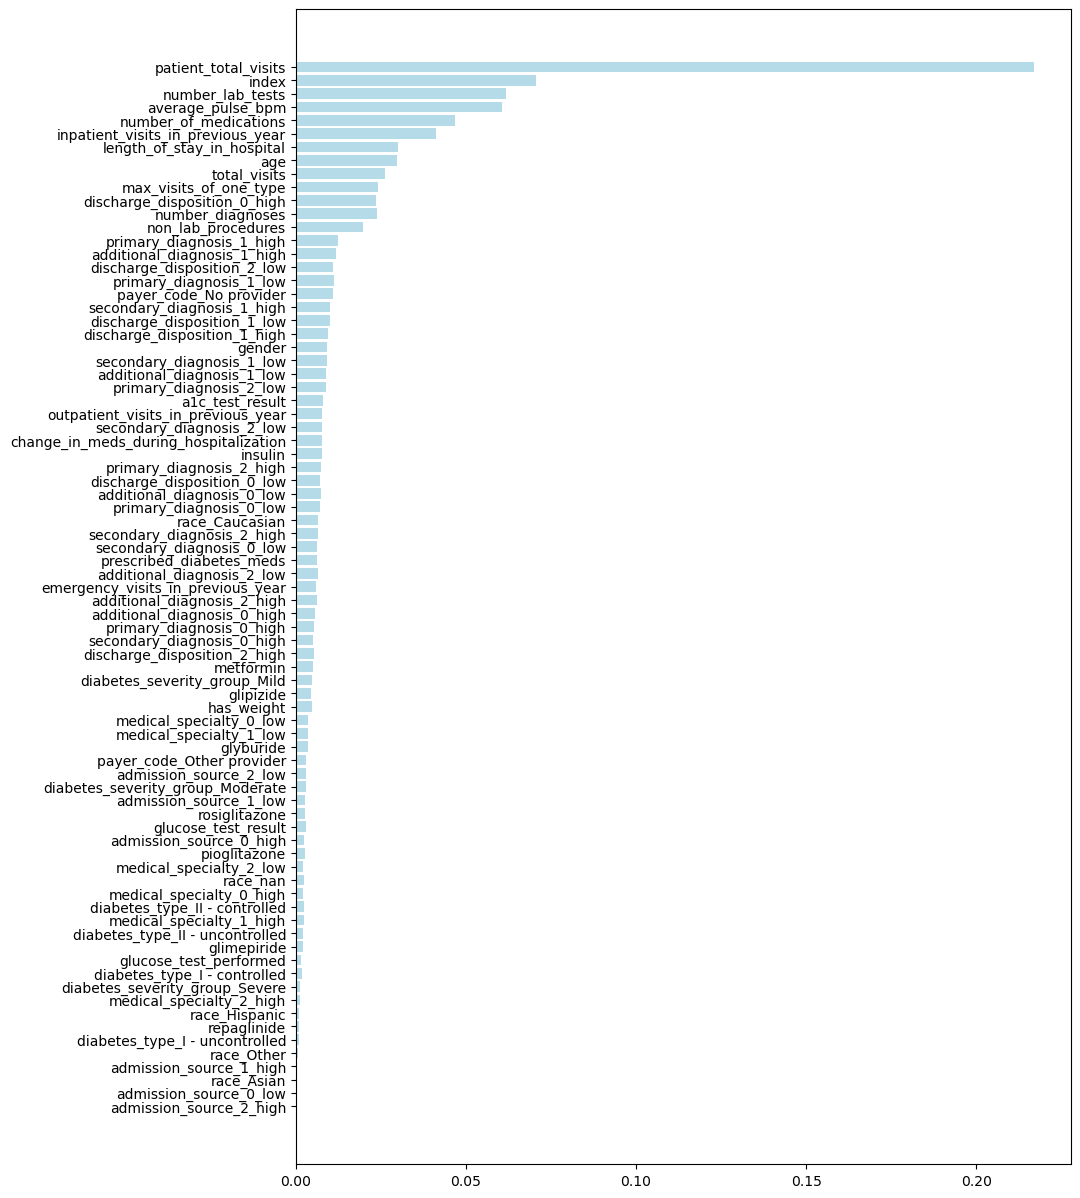

In [278]:
num_best_models = 10

best_models = sorted(result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

fdf = pd.DataFrame(np.array([best_models[k][4] for k in range(len(best_models))]).T)
fdf['features'] = best_models[0][3]
fdf.set_index('features', inplace = True)
ranked_df = fdf.rank(ascending=False)
ranked_df['median_rank'] = ranked_df.median(axis=1)
ranked_df['median_feature_importance'] = fdf.median(axis=1)
ranked_df.reset_index(inplace = True)
ranked_df = ranked_df[['features', 'median_rank', 'median_feature_importance']]
features = ranked_df.sort_values(by = 'median_rank').head(30)['features']


plt.figure(figsize=(10, 15))
plt.barh(ranked_df.sort_values(by = 'median_rank', ascending = False)['features'], 
         ranked_df.sort_values(by = 'median_rank', ascending = False)['median_feature_importance'],
         color='lightblue',  alpha=0.9, linewidth=0, height=0.8, align='center')
         
# plt.tight_layout()
plt.show()

Check ideal number of features

In [282]:
model = RandomForestClassifier(random_state = random_state)
params = {
    'n_estimators': np.arange(50, 200, 10),
    'max_depth': np.arange(10, 20, 2),
    'min_samples_split': np.arange(0, 0.0008, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0.0002, 0.0008, 0.0002) + 0.000001,
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.2,0.5,0.1),
}

result_feature_selection = []
for i in tqdm(range(10)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
        
    for j in tqdm(range(0,80, 10)):

        features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

        columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
        columns_to_use_full.extend(['patient_id', 'encounter_id'])
                                   
        X_train = df_train[columns_to_use_full]
        y_train = df_train[target]
        
        data = pd.concat([X_train, y_train], axis = 1)
    
        result_feature_selection.append(
            (
                len(ranked_df)- j,
             cross_validation(data, 
                     target, 
                     model,
                     random_params,
                     multiclass= True,
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                              
                     upsample = False,   
                     cv=5)[1]
            )
        )

  0%|          | 0/10 [00:00<?, ?it/s]





100%|██████████| 5/5 [01:12<00:00, 14.43s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.669, F1_val: 0.632








100%|██████████| 5/5 [01:08<00:00, 13.79s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.669, F1_val: 0.632








100%|██████████| 5/5 [01:04<00:00, 12.81s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.670, F1_val: 0.632








100%|██████████| 5/5 [00:58<00:00, 11.73s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.669, F1_val: 0.631








100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.666, F1_val: 0.628








100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.657, F1_val: 0.623








100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.650, F1_val: 0.618








 10%|█         | 1/10 [07:11<1:04:47, 431.92s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000501, n_estimators=180,
                       random_state=42)
F1 train: 0.629, F1_val: 0.589








100%|██████████| 5/5 [01:16<00:00, 15.23s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.737, F1_val: 0.648








100%|██████████| 5/5 [01:13<00:00, 14.73s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.737, F1_val: 0.649








100%|██████████| 5/5 [01:09<00:00, 13.97s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.739, F1_val: 0.649








100%|██████████| 5/5 [01:02<00:00, 12.52s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.741, F1_val: 0.649








100%|██████████| 5/5 [00:56<00:00, 11.27s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.738, F1_val: 0.647








100%|██████████| 5/5 [00:50<00:00, 10.12s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.724, F1_val: 0.641








100%|██████████| 5/5 [00:42<00:00,  8.54s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.715, F1_val: 0.634








 20%|██        | 2/10 [14:56<1:00:08, 451.01s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.000201,
                       min_samples_split=0.00030100000000000005,
                       n_estimators=130, random_state=42)
F1 train: 0.693, F1_val: 0.611








100%|██████████| 5/5 [00:28<00:00,  5.65s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.652, F1_val: 0.624








100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.654, F1_val: 0.625








100%|██████████| 5/5 [00:25<00:00,  5.00s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.653, F1_val: 0.625








100%|██████████| 5/5 [00:22<00:00,  4.57s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.653, F1_val: 0.625








100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.651, F1_val: 0.624








100%|██████████| 5/5 [00:18<00:00,  3.71s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.642, F1_val: 0.618








100%|██████████| 5/5 [00:15<00:00,  3.13s/it]


RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.635, F1_val: 0.613








 30%|███       | 3/10 [17:47<37:44, 323.45s/it]  

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.2,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=1e-06, random_state=42)
F1 train: 0.609, F1_val: 0.580








100%|██████████| 5/5 [00:34<00:00,  6.88s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.729, F1_val: 0.645








100%|██████████| 5/5 [00:32<00:00,  6.55s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.730, F1_val: 0.647








100%|██████████| 5/5 [00:30<00:00,  6.16s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.731, F1_val: 0.646








100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.734, F1_val: 0.647








100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.730, F1_val: 0.645








100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.716, F1_val: 0.638








100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.705, F1_val: 0.633








 40%|████      | 4/10 [21:19<27:55, 279.20s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.000201, min_samples_split=1e-06,
                       n_estimators=80, random_state=42)
F1 train: 0.682, F1_val: 0.608








100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.707, F1_val: 0.642








100%|██████████| 5/5 [00:27<00:00,  5.48s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.707, F1_val: 0.641








100%|██████████| 5/5 [00:25<00:00,  5.01s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.706, F1_val: 0.640








100%|██████████| 5/5 [00:23<00:00,  4.61s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.705, F1_val: 0.640








100%|██████████| 5/5 [00:20<00:00,  4.09s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.702, F1_val: 0.638








100%|██████████| 5/5 [00:17<00:00,  3.58s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.690, F1_val: 0.632








100%|██████████| 5/5 [00:15<00:00,  3.00s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.683, F1_val: 0.627








 50%|█████     | 5/10 [24:08<19:57, 239.60s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=50,
                       random_state=42)
F1 train: 0.664, F1_val: 0.603








100%|██████████| 5/5 [00:52<00:00, 10.43s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.700, F1_val: 0.641








100%|██████████| 5/5 [00:49<00:00,  9.94s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.700, F1_val: 0.640








100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.700, F1_val: 0.639








100%|██████████| 5/5 [00:42<00:00,  8.52s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.700, F1_val: 0.640








100%|██████████| 5/5 [00:38<00:00,  7.69s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.695, F1_val: 0.637








100%|██████████| 5/5 [00:33<00:00,  6.69s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.685, F1_val: 0.632








100%|██████████| 5/5 [00:28<00:00,  5.60s/it]


RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.675, F1_val: 0.625








 60%|██████    | 6/10 [29:20<17:36, 264.19s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000701, n_estimators=120,
                       random_state=42)
F1 train: 0.656, F1_val: 0.601








100%|██████████| 5/5 [01:03<00:00, 12.67s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.673, F1_val: 0.633








100%|██████████| 5/5 [01:02<00:00, 12.52s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.673, F1_val: 0.633








100%|██████████| 5/5 [00:54<00:00, 10.96s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.673, F1_val: 0.633








100%|██████████| 5/5 [00:51<00:00, 10.22s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.673, F1_val: 0.633








100%|██████████| 5/5 [00:46<00:00,  9.35s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.670, F1_val: 0.631








100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.661, F1_val: 0.625








100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.655, F1_val: 0.621








 70%|███████   | 7/10 [35:42<15:07, 302.61s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.0006010000000000001,
                       min_samples_split=0.000101, n_estimators=120,
                       random_state=42)
F1 train: 0.635, F1_val: 0.593








100%|██████████| 5/5 [01:17<00:00, 15.40s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.677, F1_val: 0.636








100%|██████████| 5/5 [01:14<00:00, 14.87s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.677, F1_val: 0.636








100%|██████████| 5/5 [01:10<00:00, 14.03s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.678, F1_val: 0.636








100%|██████████| 5/5 [01:05<00:00, 13.06s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.679, F1_val: 0.636








100%|██████████| 5/5 [00:59<00:00, 11.94s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.676, F1_val: 0.633








100%|██████████| 5/5 [00:52<00:00, 10.55s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.666, F1_val: 0.628








100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.658, F1_val: 0.622








 80%|████████  | 8/10 [43:41<11:57, 358.73s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=0.000501, n_estimators=190,
                       random_state=42)
F1 train: 0.636, F1_val: 0.593








100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.659, F1_val: 0.627








100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.659, F1_val: 0.629








100%|██████████| 5/5 [00:31<00:00,  6.37s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.659, F1_val: 0.627








100%|██████████| 5/5 [00:29<00:00,  5.97s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.659, F1_val: 0.628








100%|██████████| 5/5 [00:27<00:00,  5.47s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.658, F1_val: 0.626








100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.648, F1_val: 0.621








100%|██████████| 5/5 [00:20<00:00,  4.02s/it]


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.638, F1_val: 0.615








 90%|█████████ | 9/10 [47:19<05:14, 314.88s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.000201, min_samples_split=0.000101,
                       n_estimators=140, random_state=42)
F1 train: 0.615, F1_val: 0.581








100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.709, F1_val: 0.642








100%|██████████| 5/5 [00:42<00:00,  8.51s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.709, F1_val: 0.642








100%|██████████| 5/5 [00:39<00:00,  7.88s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.708, F1_val: 0.641








100%|██████████| 5/5 [00:36<00:00,  7.25s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.707, F1_val: 0.641








100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.703, F1_val: 0.639








100%|██████████| 5/5 [00:28<00:00,  5.62s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.691, F1_val: 0.634








100%|██████████| 5/5 [00:23<00:00,  4.72s/it]


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.685, F1_val: 0.627








100%|██████████| 10/10 [51:44<00:00, 310.48s/it]

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       max_features=0.4000000000000001,
                       min_samples_leaf=0.00040100000000000004,
                       min_samples_split=1e-06, n_estimators=80,
                       random_state=42)
F1 train: 0.666, F1_val: 0.603


In [273]:
import pickle


# Store the list using pickle
with open('Learning_results/rf_feature_selection_num_features_mc.pkl', 'wb') as file:
    pickle.dump(result_feature_selection, file)

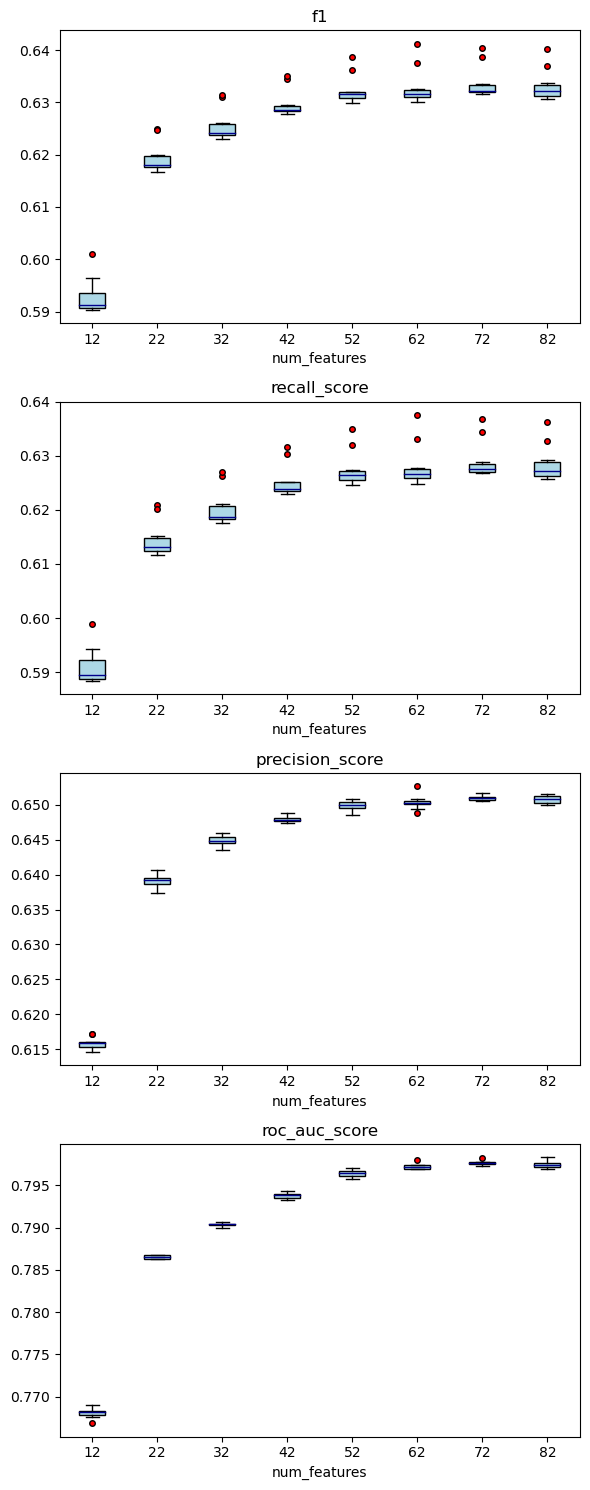

In [274]:
result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,15))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).max())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).min())
    # ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())

    ax[m].boxplot([group[1][metric].values for group in result_feature_selection_df.groupby('num_features')],
            labels = result_feature_selection_df['num_features'].unique()+3,
            patch_artist=True,
            widths=0.4,         
            medianprops=dict(color='darkblue'),
            boxprops=dict(facecolor='lightblue', edgecolor='black'),
             whiskerprops=dict(color='black'), 
             capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=4) )
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()

In [275]:
# Redefine data with new selected 50 columns 
features =  list(set(list(ranked_df.sort_values(by = 'median_rank').head(50)['features'])).intersection(set(columns_to_use)))
features.extend(['encounter_id', 'patient_id'])
X_train = df_train[features]
y_train = df_train[target]

features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(set(features)))
features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(set(features)))

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'

with open('Learning_results/selected_features_rf_mc.pkl', 'wb') as file:
    pickle.dump(features, file)

#### Logistic Regression

In [287]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result','a1c_test_result'
                              ]
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications']

columns_to_use_full = columns_to_use #+ features_for_encoding

X_train = df_train[columns_to_use_full]
y_train = df_train[target]

data = pd.concat([X_train, y_train], axis = 1)


In [290]:
model = LogisticRegression(solver='sag', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l2',
    'max_iter': 1000
}

result_log_reg = []
result_log_reg.append(cross_validation(data, 
                 target, 
                 model, 
                 params,     
                 multiclass= True,           
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                 cv=5))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [05:10<00:00, 62.00s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.605, F1_val: 0.609


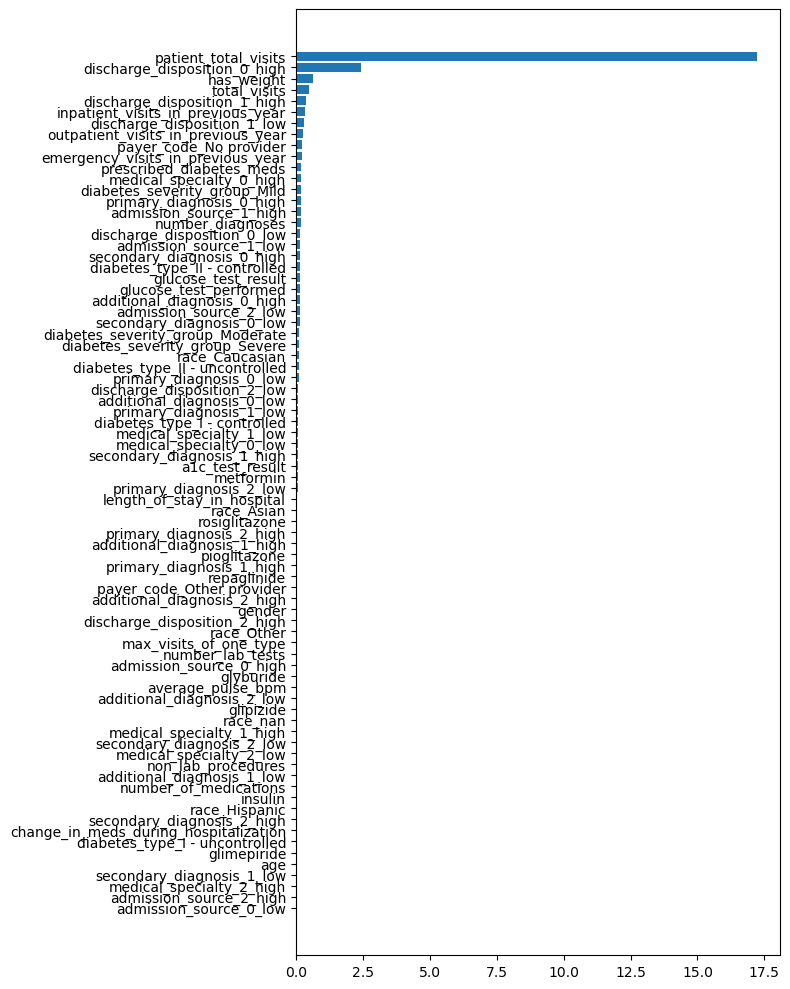

In [291]:
fdf = pd.DataFrame(np.abs(result_log_reg[0][-1][0]), columns = ['coef'])
fdf['features'] = result_log_reg[0][3]
fdf.set_index('features', inplace = True)
fdf['rank'] = fdf.rank(ascending=False)
fdf.reset_index(inplace = True)

plt.figure(figsize=(8, 10))
plt.barh(fdf.sort_values(by = 'rank', ascending = False)['features'], fdf.sort_values(by = 'rank', ascending = False)['coef'])
plt.tight_layout()
plt.show()

In [294]:
model = LogisticRegression(solver='sag', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l2',
    'max_iter': 1000
}
result_feature_selection = []

for j in tqdm(range(40,70, 3)):

    features_for_scaling_minmax = list(set(features_for_scaling_minmax).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    features_for_scaling_standard = list(set(features_for_scaling_standard).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))

    columns_to_use_full = list(set(columns_to_use).intersection(list(ranked_df.sort_values(by = 'median_rank')[:len(ranked_df)- j]['features'])))
    columns_to_use_full.extend(['patient_id', 'encounter_id'])
                               
    X_train = df_train[columns_to_use_full]
    y_train = df_train[target]

    data = pd.concat([X_train, y_train], axis = 1)

    result_feature_selection.append(
        (
            len(ranked_df)- j,
         cross_validation(data, 
                 target, 
                 model,
                 params,
                 multiclass=True,
                               
                 scaling = True,
                 features_for_scaling_minmax = features_for_scaling_minmax,
                 features_for_scaling_standard = features_for_scaling_standard,
                          
                 upsample = False,   
                 cv=5)[1]
        )
    )

 10%|█         | 1/10 [02:40<24:01, 160.22s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.598, F1_val: 0.604


 20%|██        | 2/10 [05:11<20:40, 155.06s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.598, F1_val: 0.605


 30%|███       | 3/10 [07:30<17:13, 147.60s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.597, F1_val: 0.603


 40%|████      | 4/10 [09:39<14:01, 140.19s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.593, F1_val: 0.600


 50%|█████     | 5/10 [11:36<10:59, 131.95s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.590, F1_val: 0.599


 60%|██████    | 6/10 [13:24<08:15, 123.96s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.587, F1_val: 0.595


 70%|███████   | 7/10 [14:57<05:40, 113.54s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.587, F1_val: 0.596


 80%|████████  | 8/10 [16:18<03:26, 103.43s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.587, F1_val: 0.597


 90%|█████████ | 9/10 [17:31<01:33, 93.76s/it] 

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.582, F1_val: 0.590


100%|██████████| 10/10 [18:30<00:00, 111.10s/it]

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='sag')
F1 train: 0.582, F1_val: 0.589


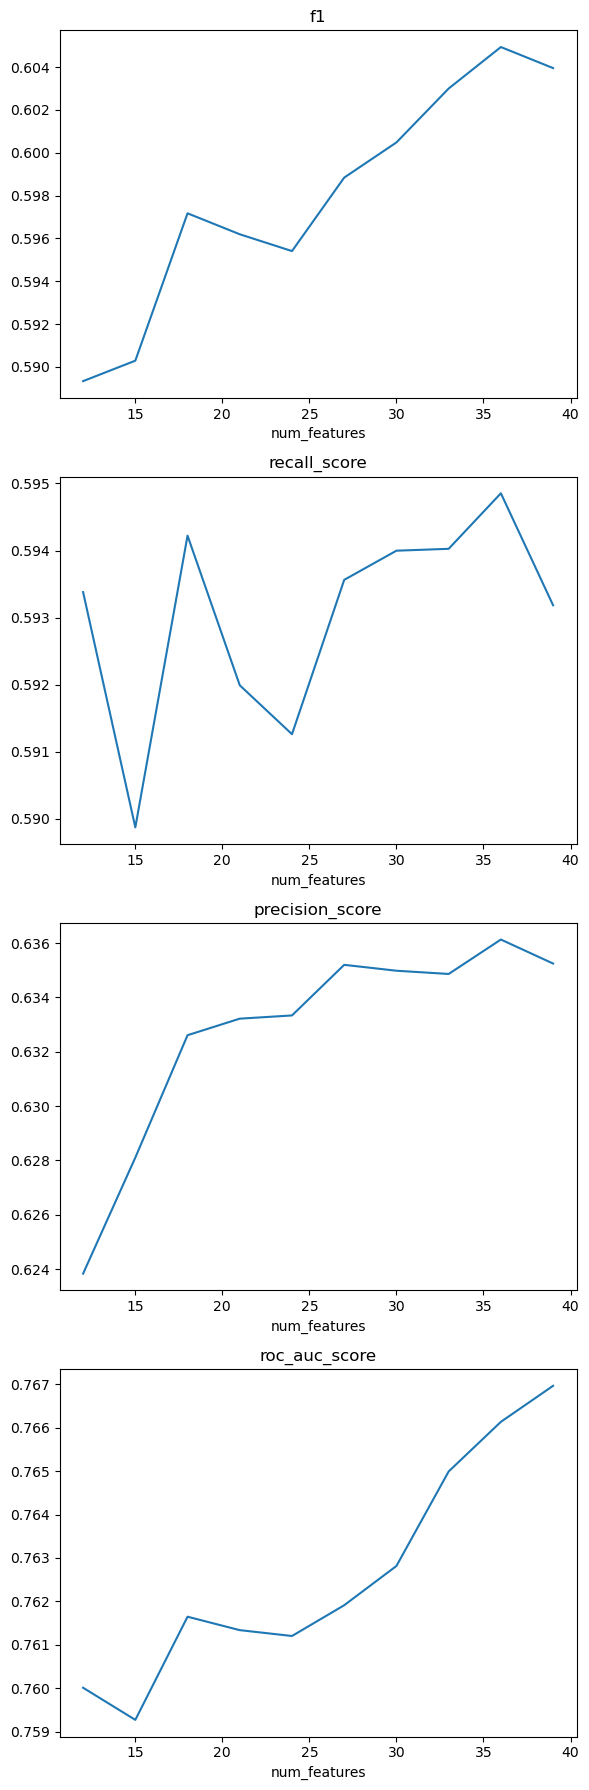

In [298]:
result_feature_selection_df = pd.DataFrame(result_feature_selection)

result_feature_selection_df[list(result_feature_selection_df[1][0].keys())] = pd.DataFrame(result_feature_selection_df[1].apply(lambda x: [x[i][1] for i in x.keys()]).apply(pd.Series)
)

result_feature_selection_df.rename(columns={0: 'num_features'}, inplace=True)
fig,ax = plt.subplots( nrows = len(list(result_feature_selection_df[1][0].keys())), figsize = (6,18))
result_feature_selection_df = result_feature_selection_df.sort_values(by='num_features')

for m in range(len(list(result_feature_selection_df[1][0].keys()))):
    metric = list(result_feature_selection_df[1][0].keys())[m]

    ax[m].plot(result_feature_selection_df[ [metric,'num_features'] ].groupby(by = ['num_features']).median())
                       
    ax[m].set_title(metric)
    ax[m].set_xlabel('num_features')

plt.tight_layout()
plt.show()

### Model Selection

#### Random Forest

In [313]:
model = RandomForestClassifier(random_state = random_state)
rf_params = {
    'n_estimators': np.arange(100, 200, 10),
    'max_depth': np.arange(10, 30, 2),
    'min_samples_split': np.arange(0.0002, 0.001, 0.0001),
    'min_samples_leaf': np.arange(0.0002, 0.001, 0.0001),
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_features': np.arange(0.1,0.9,0.1),
}

rf_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in rf_params.items():
        random_params[key] = random.choice(values)
    rf_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params,
                     multiclass=True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,    
                     upsample = False,   
                     cv=5))

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [02:46<4:35:06, 166.73s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.740, F1_val: 0.646


  2%|▏         | 2/100 [04:55<3:55:25, 144.14s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.6, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=140, random_state=42)
F1 train: 0.708, F1_val: 0.640


  3%|▎         | 3/100 [05:43<2:42:17, 100.39s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008, n_estimators=160,
                       random_state=42)
F1 train: 0.667, F1_val: 0.624


  4%|▍         | 4/100 [06:13<1:56:20, 72.72s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.1, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0005, n_estimators=120,
                       random_state=42)
F1 train: 0.615, F1_val: 0.605


  5%|▌         | 5/100 [07:30<1:57:26, 74.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=0.6, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.637, F1_val: 0.619


  6%|▌         | 6/100 [08:23<1:44:55, 66.98s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0005, n_estimators=130,
                       random_state=42)
F1 train: 0.654, F1_val: 0.624


  7%|▋         | 7/100 [08:58<1:27:36, 56.52s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.1, min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008, n_estimators=110,
                       random_state=42)
F1 train: 0.641, F1_val: 0.616


  8%|▊         | 8/100 [12:00<2:28:00, 96.52s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.6,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.725, F1_val: 0.643


  9%|▉         | 9/100 [13:48<2:31:54, 100.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.4,
                       min_samples_leaf=0.0005, min_samples_split=0.0005,
                       n_estimators=170, random_state=42)
F1 train: 0.687, F1_val: 0.634


 10%|█         | 10/100 [15:21<2:26:46, 97.85s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.5, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.706, F1_val: 0.638


 11%|█         | 11/100 [18:05<2:55:04, 118.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.8,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.673, F1_val: 0.630


 12%|█▏        | 12/100 [18:52<2:21:28, 96.46s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.1, min_samples_leaf=0.0005,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.651, F1_val: 0.619


 13%|█▎        | 13/100 [20:26<2:18:49, 95.74s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=28,
                       max_features=0.6, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0008, random_state=42)
F1 train: 0.712, F1_val: 0.640


 14%|█▍        | 14/100 [22:46<2:36:37, 109.28s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.5,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.733, F1_val: 0.645


 15%|█▌        | 15/100 [24:40<2:36:35, 110.53s/it]

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.5,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.690, F1_val: 0.636


 16%|█▌        | 16/100 [27:08<2:50:35, 121.85s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.708, F1_val: 0.639


 17%|█▋        | 17/100 [29:00<2:44:36, 119.00s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0008, n_estimators=130,
                       random_state=42)
F1 train: 0.655, F1_val: 0.625


 18%|█▊        | 18/100 [29:30<2:05:55, 92.14s/it] 

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.1,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=130, random_state=42)
F1 train: 0.625, F1_val: 0.609


 19%|█▉        | 19/100 [30:38<1:54:42, 84.97s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.2,
                       min_samples_leaf=0.0002, min_samples_split=0.0008,
                       n_estimators=170, random_state=42)
F1 train: 0.708, F1_val: 0.640


 20%|██        | 20/100 [32:06<1:54:31, 85.89s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=110,
                       random_state=42)
F1 train: 0.660, F1_val: 0.628


 21%|██        | 21/100 [33:39<1:55:53, 88.02s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.4,
                       min_samples_leaf=0.0005,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.685, F1_val: 0.634


 22%|██▏       | 22/100 [35:50<2:11:12, 100.92s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008, n_estimators=140,
                       random_state=42)
F1 train: 0.681, F1_val: 0.633


 23%|██▎       | 23/100 [38:07<2:23:24, 111.75s/it]

RandomForestClassifier(class_weight='balanced', max_depth=14,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.677, F1_val: 0.631


 24%|██▍       | 24/100 [38:52<1:56:04, 91.64s/it] 

RandomForestClassifier(class_weight='balanced', max_depth=24, max_features=0.2,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=120, random_state=42)
F1 train: 0.654, F1_val: 0.624


 25%|██▌       | 25/100 [39:40<1:38:16, 78.62s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.2, min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.681, F1_val: 0.632


 26%|██▌       | 26/100 [42:10<2:03:16, 99.96s/it]

RandomForestClassifier(class_weight='balanced', max_depth=26, max_features=0.5,
                       min_samples_leaf=0.0002, min_samples_split=0.0002,
                       n_estimators=170, random_state=42)
F1 train: 0.780, F1_val: 0.651


 27%|██▋       | 27/100 [45:06<2:29:24, 122.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.7000000000000001, min_samples_leaf=0.0008,
                       min_samples_split=0.0005, n_estimators=190,
                       random_state=42)
F1 train: 0.663, F1_val: 0.627


 28%|██▊       | 28/100 [47:10<2:27:47, 123.17s/it]

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=0.6,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.0008, n_estimators=160,
                       random_state=42)
F1 train: 0.683, F1_val: 0.635


 29%|██▉       | 29/100 [48:51<2:17:40, 116.34s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=110, random_state=42)
F1 train: 0.656, F1_val: 0.625


 30%|███       | 30/100 [51:36<2:33:01, 131.17s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.7000000000000001, min_samples_leaf=0.0002,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=180, random_state=42)
F1 train: 0.690, F1_val: 0.637


 31%|███       | 31/100 [53:25<2:22:59, 124.33s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=22,
                       max_features=0.4,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0008, n_estimators=150,
                       random_state=42)
F1 train: 0.717, F1_val: 0.642


 32%|███▏      | 32/100 [56:51<2:48:52, 149.01s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.8,
                       min_samples_leaf=0.0005, min_samples_split=0.0005,
                       n_estimators=190, random_state=42)
F1 train: 0.698, F1_val: 0.637


 33%|███▎      | 33/100 [58:01<2:19:45, 125.16s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0004000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=130, random_state=42)
F1 train: 0.698, F1_val: 0.637


 34%|███▍      | 34/100 [59:11<1:59:24, 108.56s/it]

RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=0.2,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.661, F1_val: 0.627


 35%|███▌      | 35/100 [1:00:03<1:39:27, 91.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.678, F1_val: 0.627


 36%|███▌      | 36/100 [1:00:46<1:22:02, 76.91s/it]

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.2,
                       min_samples_leaf=0.0008, min_samples_split=0.0002,
                       n_estimators=140, random_state=42)
F1 train: 0.632, F1_val: 0.617


 37%|███▋      | 37/100 [1:02:33<1:30:18, 86.01s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.5, min_samples_leaf=0.0002,
                       min_samples_split=0.0005, n_estimators=120,
                       random_state=42)
F1 train: 0.764, F1_val: 0.649


 38%|███▊      | 38/100 [1:05:50<2:03:23, 119.41s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.8, min_samples_leaf=0.0002,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=150, random_state=42)
F1 train: 0.792, F1_val: 0.651


 39%|███▉      | 39/100 [1:07:17<1:51:25, 109.60s/it]

RandomForestClassifier(class_weight='balanced', max_depth=16, max_features=0.5,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008, n_estimators=120,
                       random_state=42)
F1 train: 0.676, F1_val: 0.631


 40%|████      | 40/100 [1:08:22<1:36:07, 96.13s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.2, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0004000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.654, F1_val: 0.624


 41%|████      | 41/100 [1:09:10<1:20:24, 81.76s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=170, random_state=42)
F1 train: 0.657, F1_val: 0.621


 42%|████▏     | 42/100 [1:10:33<1:19:22, 82.11s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=160, random_state=42)
F1 train: 0.661, F1_val: 0.626


 43%|████▎     | 43/100 [1:12:32<1:28:43, 93.40s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.8, min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=110, random_state=42)
F1 train: 0.673, F1_val: 0.630


 44%|████▍     | 44/100 [1:15:16<1:46:50, 114.47s/it]

RandomForestClassifier(class_weight='balanced', max_depth=22, max_features=0.8,
                       min_samples_leaf=0.0008, min_samples_split=0.0002,
                       n_estimators=160, random_state=42)
F1 train: 0.665, F1_val: 0.627


 45%|████▌     | 45/100 [1:17:51<1:56:05, 126.65s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_features=0.8, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.0006000000000000001,
                       n_estimators=150, random_state=42)
F1 train: 0.658, F1_val: 0.625


 46%|████▌     | 46/100 [1:18:46<1:34:34, 105.08s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.1,
                       min_samples_leaf=0.00030000000000000003,
                       min_samples_split=0.0005, n_estimators=170,
                       random_state=42)
F1 train: 0.681, F1_val: 0.628


 47%|████▋     | 47/100 [1:20:27<1:31:41, 103.80s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=24,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0007000000000000001,
                       min_samples_split=0.0009000000000000001,
                       n_estimators=190, random_state=42)
F1 train: 0.661, F1_val: 0.627


 48%|████▊     | 48/100 [1:21:20<1:16:55, 88.75s/it] 

RandomForestClassifier(class_weight='balanced_subsample', max_depth=26,
                       max_features=0.30000000000000004,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0002, random_state=42)
F1 train: 0.668, F1_val: 0.629


 49%|████▉     | 49/100 [1:24:32<1:41:46, 119.74s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=18,
                       max_features=0.7000000000000001,
                       min_samples_leaf=0.0006000000000000001,
                       min_samples_split=0.0008, n_estimators=190,
                       random_state=42)
F1 train: 0.682, F1_val: 0.633


 50%|█████     | 50/100 [1:27:31<1:54:30, 137.42s/it]

RandomForestClassifier(class_weight='balanced_subsample', max_depth=14,
                       max_features=0.8, min_samples_leaf=0.0009000000000000001,
                       min_samples_split=0.00030000000000000003,
                       n_estimators=170, random_state=42)
F1 train: 0.656, F1_val: 0.625


 51%|█████     | 51/100 [1:30:14<1:58:31, 145.12s/it]

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.6,
                       min_samples_leaf=0.0002,
                       min_samples_split=0.0007000000000000001,
                       n_estimators=170, random_state=42)
F1 train: 0.748, F1_val: 0.647


In [ ]:
best_rf = sorted(rf_result, key = lambda x: -x[1]['f1'][1])[0]
print('Best Model: {}'.format(RandomForestClassifier(**best_rf[0])))
print('F1: {}'.format(round(best_rf[1]['f1'][1],4)))

#### Gradient Boosting

In [ ]:
#simple upsampling is the best approach here

model = GradientBoostingClassifier(random_state = random_state)

gb_params = {
    'n_estimators': np.arange(50, 300, 20),
    'max_depth': np.arange(1, 10, 1),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5,1.1,0.1),
    'min_samples_split': np.arange(0, 0.001, 0.0001) + 0.000001,
    'min_samples_leaf': np.arange(0, 0.002, 0.0002) + 0.000001,
    'loss': ['exponential', 'log_loss'],
    'max_features': np.arange(0.1,0.7,0.1),
}

gb_result = []
for i in tqdm(range(100)):
    random_params = {}
    for key, values in gb_params.items():
        random_params[key] = random.choice(values)
        
    gb_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass=True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))
    

In [ ]:
with open('Learning_results/gb_model_selection.pkl', 'wb') as file:
    pickle.dump(gb_result, file)

In [ ]:
num_best_models = 90

best_models = sorted(gb_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(gb_result, gb_params, best_models, figsize_param = (30,40))

MLP Classifier

In [ ]:
model = MLPClassifier(verbose = False)

params = {
    'hidden_layer_sizes': [(50, 50), (100,), (30,30)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [50]
}

mlp_upsample_params = []
mlp_result = []
for i in tqdm(range(30)):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    
    mlp_result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass = True,
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,
                     upsample = True, 
                     upsample_type = 'simple',
                     cv=5))

In [ ]:
num_best_models = 95

best_models = sorted(mlp_result, key = lambda x: -x[1]['f1'][1])[:num_best_models]

plot_metrics(mlp_result, params, best_models, figsize_param = (30,40))

#### Logistic Regression

In [ ]:
model = LogisticRegression(solver='sag', max_iter = 200, 
                           class_weight = 'balanced', random_state = random_state )
params = {
    'penalty': 'l2',
    'max_iter': 1000
}

result = []
for i in range(10):
    random_params = {}
    for key, values in params.items():
        random_params[key] = random.choice(values)
    result.append(cross_validation(data, 
                     target, 
                     model, 
                     random_params, 
                     multiclass=True,
                                   
                     scaling = True,
                     features_for_scaling_minmax = features_for_scaling_minmax,
                     features_for_scaling_standard = features_for_scaling_standard,

                     target_encoding = True,

                     upsample = False, 
                     cv=5))